In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
payment = pd.read_csv("D:\Documents\Moneylion\Data\payment.csv")

In [3]:
payment.head()

,loanId,installmentIndex,isCollection,paymentDate,principal,fees,paymentAmount,paymentStatus,paymentReturnCode
0,LL-I-00000021,1,False,2014-12-19T05:00:00,22.33,147.28,169.61,Checked,NaN
1,LL-I-00000021,2,False,2015-01-02T05:00:00,26.44,143.17,169.61,Checked,NaN
2,LL-I-00000021,3,False,2015-01-16T05:00:00,31.30,138.31,169.61,Checked,NaN
3,LL-I-00000021,4,False,2015-01-30T05:00:00,37.07,132.54,169.61,Checked,NaN
4,LL-I-00000021,5,False,2015-02-13T05:00:00,43.89,125.72,169.61,Checked,NaN


In [4]:
payment.shape

(689364, 9)

In [5]:
payment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689364 entries, 0 to 689363
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loanId             689364 non-null  object 
 1   installmentIndex   689364 non-null  int64  
 2   isCollection       689364 non-null  bool   
 3   paymentDate        689364 non-null  object 
 4   principal          689364 non-null  float64
 5   fees               689364 non-null  float64
 6   paymentAmount      689364 non-null  float64
 7   paymentStatus      689364 non-null  object 
 8   paymentReturnCode  31533 non-null   object 
dtypes: bool(1), float64(3), int64(1), object(4)
memory usage: 42.7+ MB


In [6]:
payment.isnull().sum()

loanId                    0
installmentIndex          0
isCollection              0
paymentDate               0
principal                 0
fees                      0
paymentAmount             0
paymentStatus             0
paymentReturnCode    657831
dtype: int64

In [7]:
# change data type for some column

payment = payment.astype({'paymentDate' : 'datetime64', 
                          'paymentStatus' : 'category',
                          'paymentReturnCode' : 'category'})

In [8]:
payment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689364 entries, 0 to 689363
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   loanId             689364 non-null  object        
 1   installmentIndex   689364 non-null  int64         
 2   isCollection       689364 non-null  bool          
 3   paymentDate        689364 non-null  datetime64[ns]
 4   principal          689364 non-null  float64       
 5   fees               689364 non-null  float64       
 6   paymentAmount      689364 non-null  float64       
 7   paymentStatus      689364 non-null  category      
 8   paymentReturnCode  31533 non-null   category      
dtypes: bool(1), category(2), datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 33.5+ MB


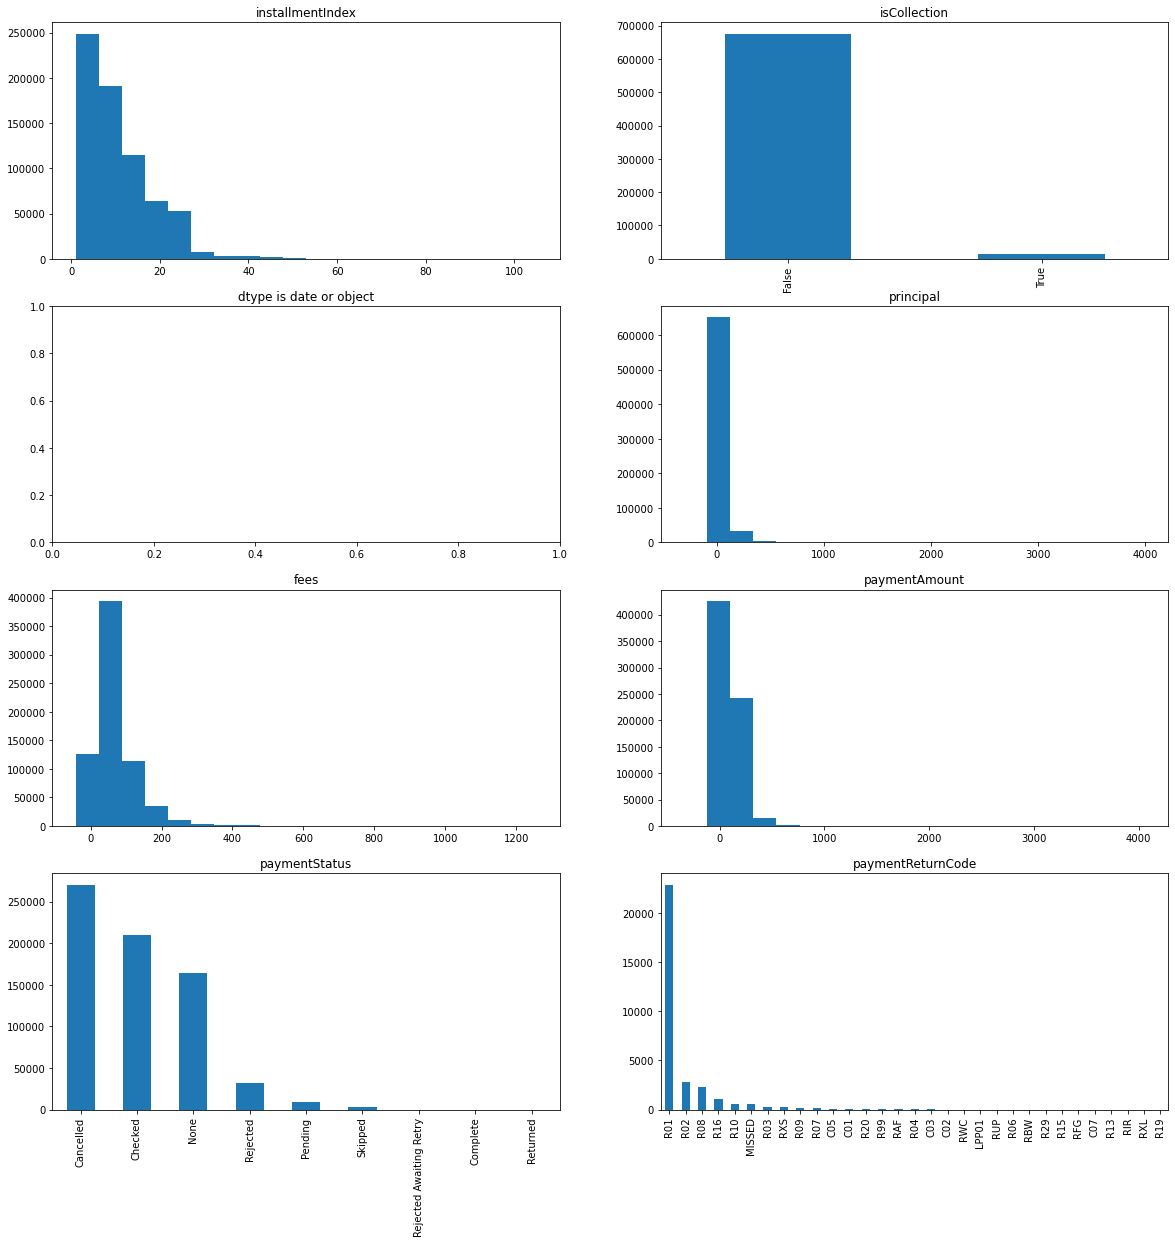

In [9]:
figs, axs = plt.subplots(4, 2, figsize=(20, 20))
axs = axs.ravel()

for i in range(1,len(payment.columns)):
    col = payment.columns[i]
    
    if payment[col].dtype == 'float' or payment[col].dtype == 'int64':
        axs[i-1].hist(payment[col], bins=20)
        axs[i-1].set_title(col)
        
    elif payment[col].dtype == 'category' or payment[col].dtype == 'bool':
        counts = payment[col].value_counts()
        counts.plot(kind = 'bar', ax = axs[i-1], title = col)
    else:
        axs[i-1].set_title('dtype is date or object')

From the above histogram, we notice the followings:
1) All of the columns with numerical data type i.e. ```installmentIndex```, ```principal```, ```fees```, ```paymentAmount``` are positively skewed. Certainly there's outlier in the data but it doesn't necessarily means it's an error. For instance, there will be borrowers who pay off their loan at one lump sum which leads to large amount in ```principal``` and ```paymentAmount```, and in other case there's borrower who prefer to repay their loan in small repayment amount and hence leads to high ```installmentIndex```.

2) There's 2 additional categories in ```paymentStatus``` i.e. 'Complete' and 'Returned' which are not supposed to be there.

3) There's is negative value in the ```principal```, ```fees```, ```paymentAmount```.

We will inspect on the data that met the 2) and 3) findings.

In [10]:
# inspect data with paymentStatus 'Complete' and 'Returned'
payment[(payment['paymentStatus'] == 'Complete') | (payment['paymentStatus'] == 'Returned')]

,loanId,installmentIndex,isCollection,paymentDate,principal,fees,paymentAmount,paymentStatus,paymentReturnCode
1350,LL-I-00023984,1,False,2014-12-19 05:00:00,0.00,25.07,25.07,Returned,R07
373456,LL-I-12152161,1,False,2016-12-02 05:00:00,21.05,78.95,100.00,Complete,NaN


From Veri Check, R07 indicates Authorization	Revoked	by	Customer	(adjustment	entries). So we would replace 'Returned' with 'Cancelled'. For 'Complete', we will replace it with 'Checked'.

In [11]:
payment['paymentStatus'].replace('Complete', 'Checked', inplace=True)
payment['paymentStatus'].replace('Returned', 'Cancelled', inplace=True)

In [12]:
# inspect data with negative 'principal', 'fees' and 'paymentAmount'
# we are interested in the payment that are successful, so we check whether the value count of 'checked' in is more than 0
negativePayment = payment[(payment['principal'] < 0) | 
                          (payment['fees'] < 0) | 
                          (payment['paymentAmount'] < 0)]
negativePayment.paymentStatus.value_counts()

Cancelled                  29
Checked                     3
None                        0
Pending                     0
Rejected                    0
Rejected Awaiting Retry     0
Skipped                     0
Name: paymentStatus, dtype: int64

In [13]:
negativePayment[negativePayment['paymentStatus'] == 'Checked']

,loanId,installmentIndex,isCollection,paymentDate,principal,fees,paymentAmount,paymentStatus,paymentReturnCode
241343,LL-I-08802275,28,False,2016-11-03 16:46:16.647,10.41,-0.92,137.99,Checked,NaN
370481,LL-I-12122640,1,False,2016-11-18 05:00:00.000,-11.01,77.44,66.43,Checked,NaN
370561,LL-I-12122658,1,False,2016-11-18 05:00:00.000,-4.22,93.47,89.25,Checked,NaN


**Conclusion**: Nothing insightful. We can just ignore it. Negative value appear might due to overpayment in previous payment.

,installmentIndex,isCollection,principal,fees,paymentAmount
installmentIndex,1.000000,-0.074657,0.046457,-0.363816,-0.170524
isCollection,-0.074657,1.000000,0.080290,-0.114381,-0.000233
principal,0.046457,0.080290,1.000000,0.089111,0.824481
fees,-0.363816,-0.114381,0.089111,1.000000,0.634756
paymentAmount,-0.170524,-0.000233,0.824481,0.634756,1.000000


<AxesSubplot:>

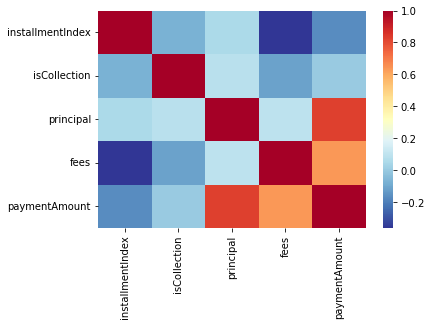

In [14]:
# Glimpse on the correlation 
paymentCorr = payment.corr()
display(paymentCorr)
sns.heatmap(paymentCorr, cmap = plt.cm.RdYlBu_r)

**Comment**:
* ```principal``` and ```fees``` have strong positive correlation with ```paymentAmount``` as ```paymentAmount``` is the sum of the both ```principal``` and ```fees```
* ```installmentIndex``` has negative correlation with ```fees```. This is because as ```installmentIndex``` increase, ```principal``` decrease and leads to ```fees``` decrease, where ```fees```consist of interest amount.
* ```principal``` is normally fixed hence very low correlation with other column except ```paymentAmount``` which depends on it.

Now we want to create a table such that there's only one row for each ```loanId``` so that it will allow us to merge ```payment``` table with the ```loan``` table.

### Framework on transforming ```payment``` table 

```loanId``` : unique ```loanId``` from the original table

```isCollection``` : If ```loanId``` has at least one True in ```isCollection```, then ```isCollection``` in new table would be 1, else would be 0.

```paymentDate``` : Only keep the first repayment date

```numInstallmentFalse``` : total number of installment payment made under original payment plan (including unsuccessful payment)

```numInstallmentTrue``` : total number of installment payment made under custom made payment plan (including unsuccessful payment)

```principalPayment``` : total principal payment amount given the ```paymentStatus``` is 'Checked', 'None' or 'Pending'

```feesPayment``` : total fees payment amount given the ```paymentStatus``` is 'Checked', 'None' or 'Pending'

```totalPayment``` : sum of ```principalPayment``` and ```feesPayment```

```paymentStatus``` : use pivot table to count each category on a ```loanId```

```paymentReturnCode```: use pivot table to count each category on a ```loanId```


#### Create ```loanId```

In [15]:
payment_df = pd.DataFrame({'loanId' : payment.loanId.unique()})
payment_df

,loanId
0,LL-I-00000021
1,LL-I-00000231
2,LL-I-00000238
3,LL-I-00000308
4,LL-I-00000355
...,...
39947,LL-I-18625988
39948,LL-I-18627784
39949,LL-I-18629093
39950,LL-I-18629196


#### Create ```isCollection```

In [16]:
isCollectionTrue = payment[payment['isCollection'] == True].loanId.unique()
payment_df['isCollection'] = np.where(payment_df['loanId'].isin(isCollectionTrue), 1, 0)
payment_df

,loanId,isCollection
0,LL-I-00000021,1
1,LL-I-00000231,0
2,LL-I-00000238,0
3,LL-I-00000308,0
4,LL-I-00000355,0
...,...,...
39947,LL-I-18625988,0
39948,LL-I-18627784,0
39949,LL-I-18629093,0
39950,LL-I-18629196,0


#### Create ```paymentDate```

In [17]:
payment_df['paymentDate'] = payment.drop_duplicates(subset = 'loanId', keep = 'first')['paymentDate'].reset_index(drop = True)
payment_df

,loanId,isCollection,paymentDate
0,LL-I-00000021,1,2014-12-19 05:00:00
1,LL-I-00000231,0,2014-12-11 05:00:00
2,LL-I-00000238,0,2014-12-15 05:00:00
3,LL-I-00000308,0,2015-01-05 05:00:00
4,LL-I-00000355,0,2014-12-11 05:00:00
...,...,...,...
39947,LL-I-18625988,0,2017-03-31 04:00:00
39948,LL-I-18627784,0,2017-03-31 04:00:00
39949,LL-I-18629093,0,2017-04-07 04:00:00
39950,LL-I-18629196,0,2017-03-31 04:00:00


#### Create ```numInstallmentFalse``` & ```numInstallmentTrue```

In [18]:
numInstallment_F = payment[payment['isCollection']==False].groupby('loanId', sort=False)['installmentIndex'].max().reset_index(drop=True)
payment_df['numInstallmentFalse'] = numInstallment_F
payment_df

,loanId,isCollection,paymentDate,numInstallmentFalse
0,LL-I-00000021,1,2014-12-19 05:00:00,12
1,LL-I-00000231,0,2014-12-11 05:00:00,20
2,LL-I-00000238,0,2014-12-15 05:00:00,16
3,LL-I-00000308,0,2015-01-05 05:00:00,22
4,LL-I-00000355,0,2014-12-11 05:00:00,23
...,...,...,...,...
39947,LL-I-18625988,0,2017-03-31 04:00:00,12
39948,LL-I-18627784,0,2017-03-31 04:00:00,12
39949,LL-I-18629093,0,2017-04-07 04:00:00,13
39950,LL-I-18629196,0,2017-03-31 04:00:00,13


In [19]:
numInstallment_T = payment[payment['isCollection']==True].groupby('loanId', sort=False)['installmentIndex'].max().reset_index()
temp_nIT = pd.merge(payment_df, numInstallment_T, how = 'left', on = 'loanId').fillna(0).astype({'installmentIndex' : 'int64'})
payment_df['numInstallmentTrue'] = temp_nIT['installmentIndex']
payment_df

,loanId,isCollection,paymentDate,numInstallmentFalse,numInstallmentTrue
0,LL-I-00000021,1,2014-12-19 05:00:00,12,1
1,LL-I-00000231,0,2014-12-11 05:00:00,20,0
2,LL-I-00000238,0,2014-12-15 05:00:00,16,0
3,LL-I-00000308,0,2015-01-05 05:00:00,22,0
4,LL-I-00000355,0,2014-12-11 05:00:00,23,0
...,...,...,...,...,...
39947,LL-I-18625988,0,2017-03-31 04:00:00,12,0
39948,LL-I-18627784,0,2017-03-31 04:00:00,12,0
39949,LL-I-18629093,0,2017-04-07 04:00:00,13,0
39950,LL-I-18629196,0,2017-03-31 04:00:00,13,0


#### Create ```principalPayment```

In [20]:
filterPayment = payment.loc[(payment['paymentStatus'] == 'Checked') | 
                               (payment['paymentStatus'] == 'None') |
                               (payment['paymentStatus'] == 'Pending')]
principalPayment = filterPayment.groupby('loanId', sort = False)['principal'].sum().reset_index()
tempPP = pd.merge(payment_df, principalPayment, how='left', on='loanId').fillna(0)
payment_df['principalPayment'] = tempPP['principal']
payment_df

,loanId,isCollection,paymentDate,numInstallmentFalse,numInstallmentTrue,principalPayment
0,LL-I-00000021,1,2014-12-19 05:00:00,12,1,697.84
1,LL-I-00000231,0,2014-12-11 05:00:00,20,0,729.67
2,LL-I-00000238,0,2014-12-15 05:00:00,16,0,725.04
3,LL-I-00000308,0,2015-01-05 05:00:00,22,0,195.33
4,LL-I-00000355,0,2014-12-11 05:00:00,23,0,500.00
...,...,...,...,...,...,...
39947,LL-I-18625988,0,2017-03-31 04:00:00,12,0,1000.00
39948,LL-I-18627784,0,2017-03-31 04:00:00,12,0,400.00
39949,LL-I-18629093,0,2017-04-07 04:00:00,13,0,500.00
39950,LL-I-18629196,0,2017-03-31 04:00:00,13,0,1500.00


#### Create ```feesPayment```

In [21]:
feesPayment = filterPayment.groupby('loanId', sort = False)['fees'].sum().reset_index()
tempF = pd.merge(payment_df, feesPayment, how='left', on='loanId').fillna(0)
payment_df['feesPayment'] = tempF['fees']
payment_df

,loanId,isCollection,paymentDate,numInstallmentFalse,numInstallmentTrue,principalPayment,feesPayment
0,LL-I-00000021,1,2014-12-19 05:00:00,12,1,697.84,1167.77
1,LL-I-00000231,0,2014-12-11 05:00:00,20,0,729.67,924.68
2,LL-I-00000238,0,2014-12-15 05:00:00,16,0,725.04,1135.35
3,LL-I-00000308,0,2015-01-05 05:00:00,22,0,195.33,482.16
4,LL-I-00000355,0,2014-12-11 05:00:00,23,0,500.00,699.46
...,...,...,...,...,...,...,...
39947,LL-I-18625988,0,2017-03-31 04:00:00,12,0,1000.00,4145.66
39948,LL-I-18627784,0,2017-03-31 04:00:00,12,0,400.00,791.45
39949,LL-I-18629093,0,2017-04-07 04:00:00,13,0,500.00,1255.78
39950,LL-I-18629196,0,2017-03-31 04:00:00,13,0,1500.00,1722.20


#### Create ```totalPayment```

In [22]:
payment_df['totalPayment'] = payment_df['principalPayment'] + payment_df['feesPayment']
payment_df

,loanId,isCollection,paymentDate,numInstallmentFalse,numInstallmentTrue,principalPayment,feesPayment,totalPayment
0,LL-I-00000021,1,2014-12-19 05:00:00,12,1,697.84,1167.77,1865.61
1,LL-I-00000231,0,2014-12-11 05:00:00,20,0,729.67,924.68,1654.35
2,LL-I-00000238,0,2014-12-15 05:00:00,16,0,725.04,1135.35,1860.39
3,LL-I-00000308,0,2015-01-05 05:00:00,22,0,195.33,482.16,677.49
4,LL-I-00000355,0,2014-12-11 05:00:00,23,0,500.00,699.46,1199.46
...,...,...,...,...,...,...,...,...
39947,LL-I-18625988,0,2017-03-31 04:00:00,12,0,1000.00,4145.66,5145.66
39948,LL-I-18627784,0,2017-03-31 04:00:00,12,0,400.00,791.45,1191.45
39949,LL-I-18629093,0,2017-04-07 04:00:00,13,0,500.00,1255.78,1755.78
39950,LL-I-18629196,0,2017-03-31 04:00:00,13,0,1500.00,1722.20,3222.20


#### Create ```paymentStatus```

In [23]:
pS_table = pd.pivot_table(payment, index = 'loanId', columns = 'paymentStatus', 
                          values = 'isCollection', aggfunc = 'count', fill_value = 0)

In [24]:
tempPS = pd.merge(payment_df, pS_table, how='left', on='loanId')

for col in pS_table.columns:
    payment_df[col] = tempPS[col] # can only run once. delete the column using the code below and rerun again if needed

#payment_df.drop(pS_table.columns, axis=1, inplace = True)

In [25]:
payment_df

,loanId,isCollection,paymentDate,numInstallmentFalse,numInstallmentTrue,principalPayment,feesPayment,totalPayment,Cancelled,Checked,None,Pending,Rejected,Rejected Awaiting Retry,Skipped
0,LL-I-00000021,1,2014-12-19 05:00:00,12,1,697.84,1167.77,1865.61,0,12,0,0,1,0,0
1,LL-I-00000231,0,2014-12-11 05:00:00,20,0,729.67,924.68,1654.35,8,2,8,0,2,0,0
2,LL-I-00000238,0,2014-12-15 05:00:00,16,0,725.04,1135.35,1860.39,4,7,4,0,1,0,0
3,LL-I-00000308,0,2015-01-05 05:00:00,22,0,195.33,482.16,677.49,10,1,10,0,1,0,0
4,LL-I-00000355,0,2014-12-11 05:00:00,23,0,500.00,699.46,1199.46,11,0,11,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39947,LL-I-18625988,0,2017-03-31 04:00:00,12,0,1000.00,4145.66,5145.66,0,0,12,0,0,0,0
39948,LL-I-18627784,0,2017-03-31 04:00:00,12,0,400.00,791.45,1191.45,0,0,12,0,0,0,0
39949,LL-I-18629093,0,2017-04-07 04:00:00,13,0,500.00,1255.78,1755.78,0,0,13,0,0,0,0
39950,LL-I-18629196,0,2017-03-31 04:00:00,13,0,1500.00,1722.20,3222.20,0,0,13,0,0,0,0


#### Create ```paymentReturnCode```

In [26]:
pRC_table = pd.pivot_table(payment, index = 'loanId', columns = 'paymentReturnCode', 
                           values = 'isCollection', aggfunc = 'count', fill_value = 0)

In [27]:
tempPRC = pd.merge(payment_df, pRC_table, how='left', on='loanId')

for col in pRC_table.columns:
    payment_df[col] = tempPRC[col] # can only run once. Delete the column using the code below and rerun again if needed

#payment_df.drop(pRC_table.columns, axis=1, inplace = True)

In [28]:
payment_df

,loanId,isCollection,paymentDate,numInstallmentFalse,numInstallmentTrue,principalPayment,feesPayment,totalPayment,Cancelled,Checked,...,R29,R99,RAF,RBW,RFG,RIR,RUP,RWC,RXL,RXS
0,LL-I-00000021,1,2014-12-19 05:00:00,12,1,697.84,1167.77,1865.61,0,12,...,0,0,0,0,0,0,0,0,0,0
1,LL-I-00000231,0,2014-12-11 05:00:00,20,0,729.67,924.68,1654.35,8,2,...,0,0,0,0,0,0,0,0,0,0
2,LL-I-00000238,0,2014-12-15 05:00:00,16,0,725.04,1135.35,1860.39,4,7,...,0,0,0,0,0,0,0,0,0,0
3,LL-I-00000308,0,2015-01-05 05:00:00,22,0,195.33,482.16,677.49,10,1,...,0,0,0,0,0,0,0,0,0,0
4,LL-I-00000355,0,2014-12-11 05:00:00,23,0,500.00,699.46,1199.46,11,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39947,LL-I-18625988,0,2017-03-31 04:00:00,12,0,1000.00,4145.66,5145.66,0,0,...,0,0,0,0,0,0,0,0,0,0
39948,LL-I-18627784,0,2017-03-31 04:00:00,12,0,400.00,791.45,1191.45,0,0,...,0,0,0,0,0,0,0,0,0,0
39949,LL-I-18629093,0,2017-04-07 04:00:00,13,0,500.00,1255.78,1755.78,0,0,...,0,0,0,0,0,0,0,0,0,0
39950,LL-I-18629196,0,2017-03-31 04:00:00,13,0,1500.00,1722.20,3222.20,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# convert payment_df dataframe into csv
payment_df.to_csv('paymentCleaned.csv')

In [30]:
payment_df['isCollection'].value_counts(normalize=True)

0    0.939077
1    0.060923
Name: isCollection, dtype: float64

**End of working file. Please refer to the `loan` working file for more details.**